In [1]:
# Basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Model imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Data processing

We start by importing our processed data, dropping columns unhelpful for classification, and separating the features from the target column.

In [2]:
dnd = pd.read_csv("dnd_monsters_processed.csv").drop(columns=["Index", "name"])
features = dnd.drop(columns=["cr"])
target = dnd.cr

Here's what the complete dataset looks like.

In [3]:
dnd

,size,type,alignment,ac,hp,cr,speed,swim,climb,fly,burrow,strength,dex,con,intel,wis,cha,legendary
0,2,0,0,12.0,13,0.250,20,0,0,50,0,10,14,10,11,12,11,0
1,2,1,1,12.0,84,9.000,30,0,0,0,0,9,14,14,18,12,11,0
2,3,2,2,17.0,135,10.000,10,40,0,0,0,21,9,15,18,15,18,1
3,4,3,3,15.0,137,9.000,40,0,40,0,0,24,10,22,9,13,9,0
4,2,4,4,21.0,285,23.000,30,0,0,0,0,13,16,20,27,21,20,0
5,2,1,1,10.0,9,0.250,30,0,0,0,0,10,10,10,10,14,11,0
6,4,5,3,19.0,195,14.000,40,40,0,80,0,23,14,21,14,13,17,1
7,4,4,2,19.0,225,17.000,40,0,0,80,30,25,10,23,16,15,19,1
8,4,5,2,19.0,225,16.000,40,0,0,80,30,25,10,23,16,15,19,1
9,4,5,5,18.0,172,13.000,40,0,0,80,30,23,10,21,14,13,17,1


Here's a visual for how many monsters are in each challenge rating class.

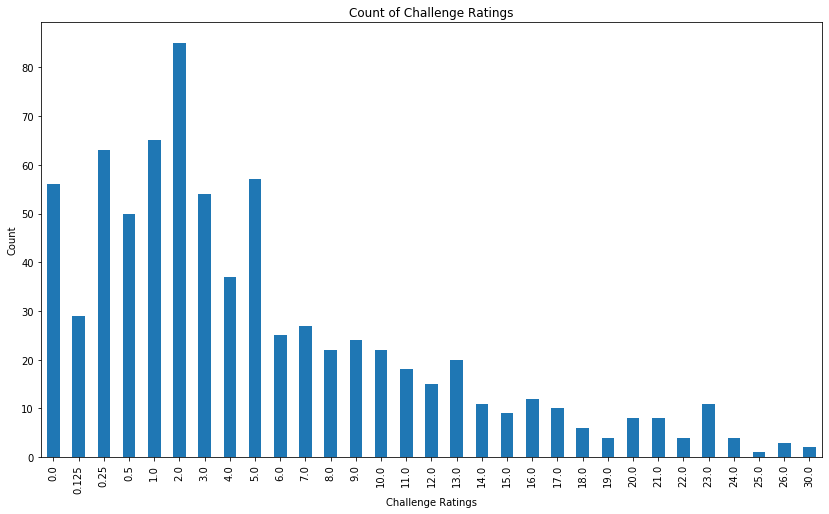

In [4]:
ax = dnd.cr.value_counts().sort_index().plot(kind='bar', figsize=(14,8),title="Count of Challenge Ratings")
ax.set_xlabel("Challenge Ratings")
ax.set_ylabel("Count")
ax

For our machine learning models we'll need to convert the features and targets to numpy arrays.

In [5]:
X = features.to_numpy()
y = target.to_numpy()

Since not all models can take real-numbered targets, we also create a shifted target vector that converts the fractional challenge ratings into the lowest-valued integers and shift the rest of the challenge ratings to accommodate them.

In [6]:
y_shift = []
for i in y:
    if i == .125:
        y_shift.append(1)
    elif i == .25:
        y_shift.append(2)
    elif i == .5:
        y_shift.append(3)
    else:
        y_shift.append(i+3)

In addition to using the whole dataset, we thought that it would be interesting to partition the dataset into different categories and test how much influence each category had. When examining the data, three main partitions stood out: general traits, mobility capabilities, and ability scores. To examine their individual impacts we created an array of modified observations with different combinations of these categories.

In [7]:
traits = ["size", "type", "alignment", "legendary"]
mobility = ["speed", "swim", "climb", "fly", "burrow"]
abilityscore = ["ac", "hp","strength", "dex", "con", "intel", "wis", "cha"]

names = ["No traits", "No mobility", "No ability score", "Only traits", "Only mobility", "Only ability score"]
X_mod = [features.drop(columns=traits)]
X_mod.append(features.drop(columns=mobility))
X_mod.append(features.drop(columns=abilityscore))
X_mod.append(features.drop(columns=mobility+abilityscore))
X_mod.append(features.drop(columns=abilityscore+traits))
X_mod.append(features.drop(columns=traits+mobility))

# Testing Tools

To run our experiments, we created a helper function that takes a model, the observations, target values, and a number of trials to run. This allowed us to easily run experiments per model and find an average score for them.

In [8]:
def test_model(model, X, y, trials):
    test = []
    train = []
    for i in range(trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y)    
        model.fit(X_train, y_train)
        train.append(model.score(X_train, y_train))
        test.append(model.score(X_test, y_test))
    return (np.mean(train), np.mean(test))

# wrapper for nice printing
def print_test_model(model, X, y, trials):
    train_mean, test_mean = test_model(model, X, y, trials)
    print("Accuracy on training set: {:.5f}".format(train_mean))
    print("Accuracy on test set: {:.5f}\n".format(test_mean))

# wrapper for nice printing and returning
def print_test_model2(model, X, y, trials):
    train_mean, test_mean = test_model(model, X, y, trials)
    print("Accuracy on training set: {:.5f}".format(train_mean))
    print("Accuracy on test set: {:.5f}\n".format(test_mean))
    return (train_mean, test_mean)

We also created a helper function to test how the model performs when using the various feature partitions. Since the partitions were based on human judgment we kept this one simple.

In [9]:
def test_model_mod(model, names, X, y, trials):
    for i in range(len(names)):
        print(names[i])
        print_test_model(model, X[i], y, 100)
        
def graph_model_mod(model, names, X, y, trials):
    acc_test = []
    acc_train = []
    for i in range(len(names)):
        train, test = test_model(model, X[i], y, trials)
        print(names[i])
        print("Accuracy on training set: {:.5f}".format(train))
        print("Accuracy on test set: {:.5f}\n".format(test))
        acc_test.append(test)
        acc_train.append(train)
    index = np.arange(len(names))
    plt.figure(figsize=(20, 10))
    plt.bar(index - .2, acc_train, color = 'blue', width=.4, label="Train")
    plt.bar(index+ .2, acc_test, color = 'orange', width=.4, label="Test")
    plt.xticks(index, names)
    plt.yticks([i*.05 for i in range(20)])
    plt.legend()
    plt.show()

Lastly, we created a function to determine which targets the model missed. Instead of running multiple trials, these functions run a model just once. The most notable feature here is the margin of error checker, which gives a nice picture of how far off the model was on average.

In [10]:
# Returns an array of (predict, true) pairs for all misclassifications
def find_missed(model, X, y):
    y_pred = model.predict(X)
    return np.array([[y_pred[i], y[i]] for i in range(len(y)) if y_pred[i] != y[i] ])
        
def test_missed_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)    
    model.fit(X_train, y_train)
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)
    
    train_missed = find_missed(model, X_train, y_train)
    test_missed = find_missed(model, X_test, y_test)
    
    return (train, train_missed, test, test_missed)

# Finds the average margin of error for a model
def find_margin(missed):
    margin = 0
    for pred, true in missed:
        margin += abs(pred-true)
    return margin/len(missed)

# Helper print functions #

# Print first n incorrect predictions
def print_missed(missed, n):
    print("Number of incorrect predictions: {}".format(len(missed)))
    print("Average margin of error: {}".format(find_margin(missed)))
    for pred, true in missed[:n]:
        print("Predicted {}, was {}".format(pred, true))
    print()
    
def print_test_missed_model(model, X, y, n):
    train, train_missed, test, test_missed = test_missed_model(model, X, y)
    print("Accuracy on training set: {:.5f}".format(train))
    print_missed(train_missed, n)
    print("Accuracy on test set: {:.5f}".format(test))
    print_missed(test_missed, n)

For each model family, we start by running the test_model function on all the features to create a baseline for expected accuracy. Next, we do a sample run to get an idea of what the model predicts incorrectly. After that, we experiment with different model parameters as applicable. Finally, we run the model against the different feature partitions to see if those have any influence.

# KNN Classification and Regression

As a baseline, we first started by trying to use knn classification and regression schemes. Since knn models cannot use continuous target values, we had to use the shifted targets. Let's start with trying out classification.

In [79]:
knn = KNeighborsClassifier(5)
print_test_model(knn, X, y_shift, 100)

Accuracy on training set: 0.47748
Accuracy on test set: 0.26723



Ouch. Not good. Let's take a look at some of the misclassifications.

In [16]:
knn = KNeighborsClassifier(5)
print_test_missed_model(knn, X, y_shift, 10)

Accuracy on training set: 0.47636
Number of incorrect predictions: 299
Average margin of error: 2.4013377926421406
Predicted 5.0, was 8.0
Predicted 1.0, was 4.0
Predicted 1.0, was 3.0
Predicted 2.0, was 3.0
Predicted 2.0, was 3.0
Predicted 2.0, was 3.0
Predicted 5.0, was 6.0
Predicted 2.0, was 1.0
Predicted 4.0, was 5.0
Predicted 20.0, was 14.0

Accuracy on test set: 0.26702
Number of incorrect predictions: 140
Average margin of error: 2.6857142857142855
Predicted 16.0, was 17.0
Predicted 4.0, was 5.0
Predicted 11.0, was 6.0
Predicted 8.0, was 10.0
Predicted 1.0, was 2.0
Predicted 3.0, was 4.0
Predicted 8.0, was 12.0
Predicted 5.0, was 7.0
Predicted 8.0, was 7.0
Predicted 15.0, was 26.0



Pretty significant number of misclassifications and a high margin of error. Let's see how regression fares.

In [75]:
knn_reg = KNeighborsRegressor(5)
print_test_model(knn_reg, X, y_shift, 100)

Accuracy on training set: 0.93164
Accuracy on test set: 0.89526



Already that looks much better. Let's see what the incorrect predictions are like this time.

In [18]:
knn_reg = KNeighborsRegressor(5)
print_test_missed_model(knn_reg, X, y_shift, 10)

Accuracy on training set: 0.92730
Number of incorrect predictions: 527
Average margin of error: 1.2614800759013296
Predicted 2.8, was 4.0
Predicted 4.4, was 5.0
Predicted 2.4, was 2.0
Predicted 10.6, was 12.0
Predicted 5.2, was 4.0
Predicted 5.0, was 4.0
Predicted 3.4, was 3.0
Predicted 3.8, was 4.0
Predicted 7.8, was 8.0
Predicted 7.6, was 7.0

Accuracy on test set: 0.90688
Number of incorrect predictions: 174
Average margin of error: 1.467816091954023
Predicted 3.8, was 3.0
Predicted 11.4, was 11.0
Predicted 7.2, was 10.0
Predicted 5.2, was 3.0
Predicted 4.4, was 5.0
Predicted 5.6, was 5.0
Predicted 15.2, was 17.0
Predicted 5.2, was 5.0
Predicted 9.2, was 12.0
Predicted 2.4, was 2.0



Note that we have many more incorrect predictions, but the margin of error has decreased by half. This smaller margin is the reason why regression scores much better overall, as the incorrect regression predictions are off by much less compared to the classification predictions. This implies that classification schemes are less appropriate for our task because they force non-continuous predictions and thus will have wider margins of error.

Since regression is more appropriate for determining challenge rating, we choose to focus on regression model families for the rest of our experiments. But first, let's see if we can improve the knn results by changing the number of neighbors.

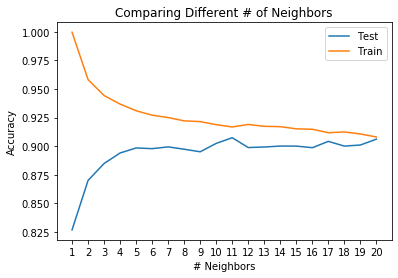

Best pos: 11
Best test mean: 0.9061252808776092


In [104]:
test_max = 0
best_pos = 0

ave_test = []
ave_train = []
neighbors = []

for i in range(1, 21):
    knn_reg = KNeighborsRegressor(i)
    train_mean, test_mean = test_model(knn_reg, X, y_shift, 20)
    ave_test.append(test_mean)
    ave_train.append(train_mean)
    neighbors.append(i)
    if (test_mean > test_max):
        test_max = test_mean
        best_pos = i

plt.plot(neighbors, ave_test, label="Test")
plt.plot(neighbors, ave_train, label="Train")
plt.title("Comparing Different # of Neighbors")
plt.xlabel("# Neighbors")
plt.ylabel("Accuracy")
plt.xticks([i for i in range(1,21)])
plt.legend()
plt.show()

print("Best pos: {}".format(best_pos))
print("Best test mean: {}".format(test_mean))

Repeating this test indicated that the best results typically occur between 12 and 18 neighbors. Sinec the accuracy was pretty consistent across tests, we'll split the difference and use 15. Now let's test this against the different partitions.

No traits
Accuracy on training set: 0.91832
Accuracy on test set: 0.90710

No mobility
Accuracy on training set: 0.92095
Accuracy on test set: 0.90600

No ability score
Accuracy on training set: 0.32601
Accuracy on test set: 0.22333

Only traits
Accuracy on training set: 0.46909
Accuracy on test set: 0.38711

Only mobility
Accuracy on training set: 0.22538
Accuracy on test set: 0.15283

Only ability score
Accuracy on training set: 0.92390
Accuracy on test set: 0.90903



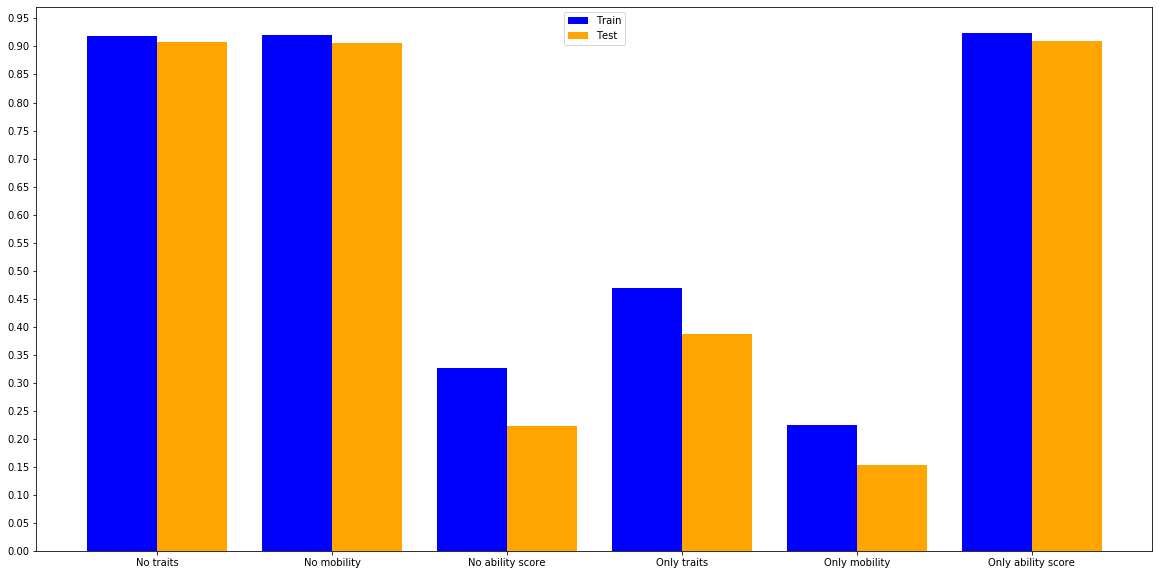

In [71]:
knn_reg = KNeighborsRegressor(15)
graph_model_mod(knn_reg, names, X_mod, y_shift, 100)
# test_model_mod(knn_reg, names, X_mod, y_shift, 100)


# Linear Regression

Our next set of tests uses the linear regression model. This ran much faster compared to knn regression, but had a slight hit to accuracy.

In [28]:
lr = LinearRegression()
print_test_model(lr, X, y, 100)

Accuracy on training set: 0.90585
Accuracy on test set: 0.88959



Now for the missed:

In [29]:
lr = LinearRegression()
print_test_missed_model(lr, X, y, 10)

Accuracy on training set: 0.90155
Number of incorrect predictions: 571
Average margin of error: 1.4147906655309879
Predicted 1.5558547857466385, was 0.25
Predicted 1.6747340881697754, was 2.0
Predicted -1.505957729137731, was 0.0
Predicted 1.0802994148418295, was 1.0
Predicted 16.50136702951294, was 20.0
Predicted 10.60915525265257, was 11.0
Predicted 23.47575951431201, was 22.0
Predicted 2.0685916369205772, was 2.0
Predicted 11.842400714864848, was 9.0
Predicted 5.702739244202472, was 6.0

Accuracy on test set: 0.90707
Number of incorrect predictions: 191
Average margin of error: 1.4064037633038295
Predicted 0.727695687416186, was 0.25
Predicted 6.157602626641489, was 7.0
Predicted -1.115778938474743, was 0.25
Predicted 3.8614912074299808, was 3.0
Predicted -0.033873505134312865, was 0.5
Predicted 8.628091197041797, was 10.0
Predicted 4.575294273487258, was 4.0
Predicted 10.986074489581497, was 10.0
Predicted 11.445645761849793, was 11.0
Predicted 9.504850995829202, was 6.0



And now for the modified features.

No traits
Accuracy on training set: 0.90365
Accuracy on test set: 0.89225

No mobility
Accuracy on training set: 0.90061
Accuracy on test set: 0.88968

No ability score
Accuracy on training set: 0.45436
Accuracy on test set: 0.43083

Only traits
Accuracy on training set: 0.42801
Accuracy on test set: 0.41997

Only mobility
Accuracy on training set: 0.19893
Accuracy on test set: 0.18335

Only ability score
Accuracy on training set: 0.89987
Accuracy on test set: 0.89024



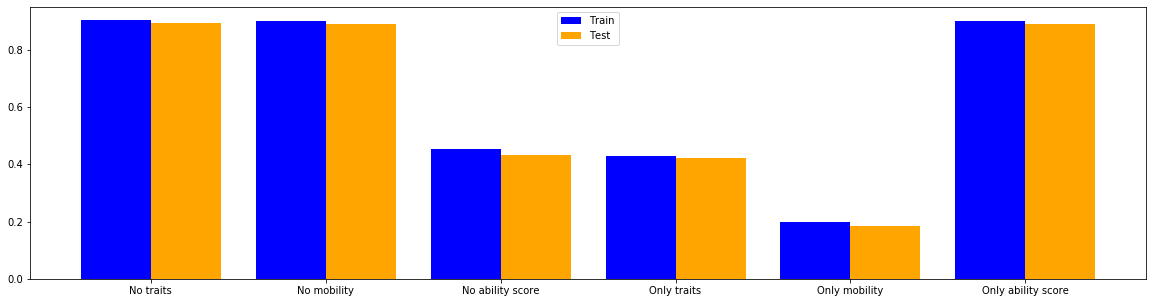

In [65]:
lr = LinearRegression()
# test_model_mod(lr, names, X_mod, y, 100)
graph_model_mod(lr, names, X_mod, y, 100)

# MLP Regression

We now move on to the multilevel perception model. Before we run the tests, we're going to ignore warnings. The MLPRegressor will warn us whenever the model doesn't converge, which gets really distracting. Later we'll adjust the maximum number of iterations for the model, which can also eliminate the convergence warnings, but for presentation purposes we'll create the filter beforehand.

In [11]:
import warnings
warnings.filterwarnings('ignore')

Now to actually test the MLP. This was the slowest to run of them all, so we had to reduce the number of trials to get results in a reasonable amount of time. As a consequence there was some more variance compared to when we ran trials on the other models, but MLPs still had the highest accuracy overall.

In [ ]:
mlp = MLPRegressor()
print_test_model(mlp, X, y, 20)

It's a slight improvement over the other models. Let's see what it gets wrong...

In [ ]:
mlp = MLPRegressor()
print_test_missed_model(mlp, X, y, 10)

Overall, it's a good baseline, but let's see if we can improve it by fiddling with some parameters. Many are solver-specific, but the following are universal parameters that we can adjust. 

First, the number of hidden layers generally improved the training accuracy, but didn't do much for the test set. If anything, test set accuracy went down slightly, which may be an indication of overfitting.

In [ ]:
# Default is [100]
hidden_layer_count = [[5]*i for i in range(1, 4)]

ave_test = []
ave_train = []

for s in hidden_layer_count:
    print("Hidden layers: {}".format(s))
    mlp = MLPRegressor(hidden_layer_sizes=s)
    train, test = print_test_model2(mlp, X, y, 20)
    ave_test.append(test)
    ave_train.append(train)

plt.plot([i for i in range(1, len(hidden_layer_count)+1)], ave_test, label="Test")
plt.plot([i for i in range(1, len(hidden_layer_count)+1)], ave_train, label="Train")
plt.title("Comparing Different # of Layers")
plt.xlabel("# of Layers")
plt.ylabel("Accuracy")
plt.xticks([i for i in range(1, len(hidden_layer_count)+1)])
plt.legend()
plt.show()

Increasing the number of hidden units in a layer followed the same trend, but the test set accuracy didn't suffer as much. In fact, by the end it improved slightly, though it's unclear how much of that came from random variance.

In [ ]:
# Default is [100]
hidden_layer_sizes = [[100*i] for i in range(1, 11)]

ave_test = []
ave_train = []

for s in hidden_layer_sizes:
    print("Hidden layer: {}".format(s))
    mlp = MLPRegressor(hidden_layer_sizes=s)
    train, test = print_test_model2(mlp, X, y, 20)
    ave_test.append(test)
    ave_train.append(train)

plt.plot([i for i in range(1, len(hidden_layer_count)+1)], ave_test, label="Test")
plt.plot([i for i in range(1, len(hidden_layer_count)+1)], ave_train, label="Train")
plt.title("Comparing Different Layer Sizes")
plt.xlabel("Layer Size")
plt.ylabel("Accuracy")
plt.xticks([i for i in range(1, len(hidden_layer_count)+1)])
plt.legend()
plt.show()

Hidden layer: [100]
Accuracy on training set: 0.95000
Accuracy on test set: 0.91262

Hidden layer: [200]


The default relu activation function works the best.

In [ ]:
# Default is relu
activation = ['relu', 'identity', 'logistic', 'tanh']
for a in activation:
    print("Activation: " + a)
    mlp = MLPRegressor(activation=a)
    print_test_model(mlp, X, y, 20)

The default adam solver has the best test accuracy, but lbfgs did have better training accuracy. The sgd solver doesn't work at all though.

In [ ]:
# Default is adam
solvers = ['adam', 'lbfgs', 'sgd']
for s in solvers:
    print("Solver: " + s)
    mlp = MLPRegressor(solver=s)
    print_test_model(mlp, X, y, 20)

Adjusting the alpha had some fluxuations but didn't result in any significant improvement.

In [12]:
# Default is 0.0001
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

ave_test = []
ave_train = []

for a in alphas:
    print("Alpha: {}".format(a))
    mlp = MLPRegressor(alpha=a)
    train, test = print_test_model2(mlp, X, y, 20)
    ave_test.append(test)
    ave_train.append(train)

plt.plot([i for i in range(1, len(hidden_layer_count)+1)], ave_test, label="Test")
plt.plot([i for i in range(1, len(hidden_layer_count)+1)], ave_train, label="Train")
plt.title("Comparing Different # of Layers")
plt.xlabel("# of Layers")
plt.ylabel("Accuracy")
plt.xticks([i for i in range(1, len(hidden_layer_count)+1)])
plt.legend()
plt.show()

Alpha: 0.0001
Accuracy on training set: 0.94928
Accuracy on test set: 0.91657

Alpha: 0.001
Accuracy on training set: 0.94827
Accuracy on test set: 0.92004

Alpha: 0.01
Accuracy on training set: 0.95033
Accuracy on test set: 0.91957

Alpha: 0.1
Accuracy on training set: 0.95231
Accuracy on test set: 0.91872

Alpha: 1
Accuracy on training set: 0.95128
Accuracy on test set: 0.91073

Alpha: 10
Accuracy on training set: 0.94864
Accuracy on test set: 0.92120

Alpha: 100
Accuracy on training set: 0.94214
Accuracy on test set: 0.91824

Alpha: 1000
Accuracy on training set: 0.91589
Accuracy on test set: 0.90512

Alpha: 10000
Accuracy on training set: 0.86444
Accuracy on test set: 0.85879



NameError: name 'hidden_layer_count' is not defined

Lastly, increasing the iteration count to allow for convergence trended towards higher overall accuracy, though this seems to be more of a question of consistency than actual improvement.

In [ ]:
# Default is 200
count = [200, 400, 600, 800, 1000]
for c in count:
    print("count: {}".format(c))
    mlp = MLPRegressor(max_iter=c)
    print_test_model(mlp, X, y, 20)

As a whole, it looks like changing individual parameters can only improve accuracy by around 1% at most. Let's try combining the best-performing parameters.

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=[800, 800], max_iter=1500)
print_test_model(mlp, X, y, 20)

Maybe a bit better, but not by much. While we could likely fine-tune the parameters to eek out more overall accuracy, it seems unlikely that it'll improve by more than a percent or two. The biggest change appears to be the amount of time the model takes to train, which may not be worth it for such small improvements.

Let's go back to the default parameters and look at the partitioned features once more.

No traits
Accuracy on training set: 0.94536
Accuracy on test set: 0.91307

No mobility
Accuracy on training set: 0.94346
Accuracy on test set: 0.92587

No ability score
Accuracy on training set: 0.53456
Accuracy on test set: 0.46896

Only traits
Accuracy on training set: 0.52249
Accuracy on test set: 0.45116

Only mobility
Accuracy on training set: 0.24016
Accuracy on test set: 0.20437

Only ability score
Accuracy on training set: 0.93666
Accuracy on test set: 0.92137



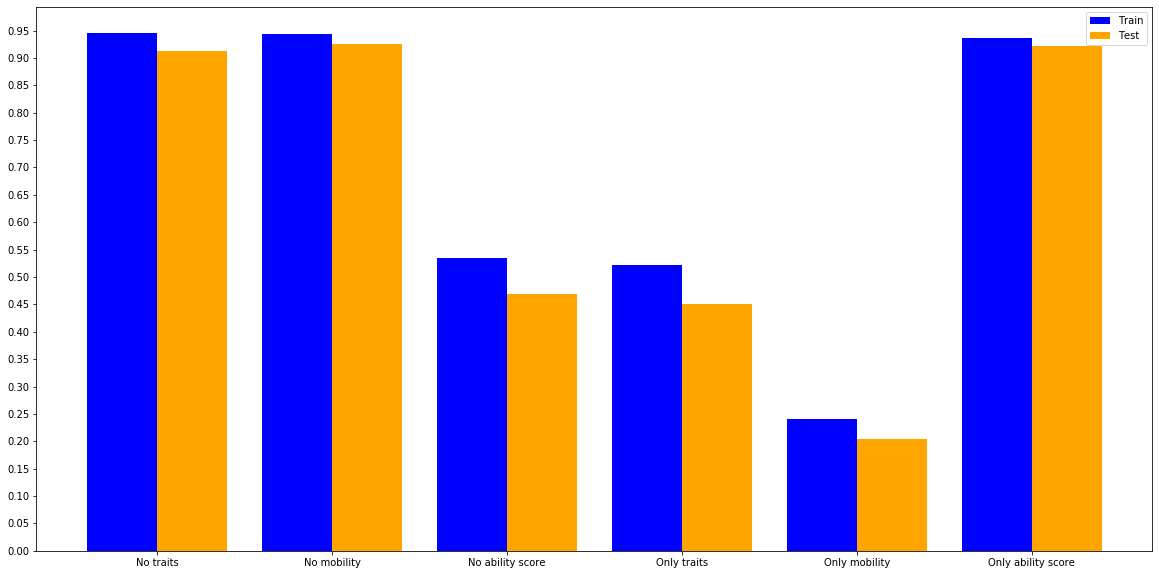

In [74]:
mlp = MLPRegressor()
# test_model_mod(mlp, names, X_mod, y, 10)
graph_model_mod(mlp, names, X_mod, y, 10)

# Conclusions

Of the models we testd, MLPs performed the best.

One possible consideration for why accuracy seems to be stuck in the 90-95% range is the distribution of challenge score ratings. As we saw with the initial graph, there's far more monsters on the lower end of the spectrum than high-ranking ones.